### Notes

- Let's try out some other libraries, like:
    - from GLM family: statsmodels and glmnet
    - GBM: xgboost and lightgbm
    - DNN: keras, neon and mxnet
- Let's use automatic ML with TPOT and autosklearn.
- In order to counter-balance the high bias of the good vs. bad loan samples (defaulted ca .93 vs good ca .07):
    - optimize the model using the 'recall' score ('recall' ca 75% is much worse than 'precision' ca 99%)
    - resample the bad loans (but that may lead to overfitting, we can try sythetizing with SMOTE)
- Experiment with clustering which might bring something new
- Finally, we've got to select the best model for testing.


### Table of Contents

- [Initialize MMS](#Initialize-MMS)
- [Load the data](#Load-the-data)
- [Some other popular ML libraries](#Some-other-popular-ML-libraries)
    - [GLM](#GLM)
    - [GBM](#GBM)
    - [DNN](#DNN)
- [Automatic ML](#Automatic-ML)
    - [TPOT](#TPOT)
    - [autosklearn](#autosklearn)
- [Counter-balancing the imbalanced cases](#Counter-balancing-the-imbalanced-cases)
    - [SMOTe](#SMOTe)
    - [Outlier detection](#Outlier-detection)
- [Clustering in search for new insights](#Clustering-in-search-for-new-insights)
- [And the best model is ...](#And-the-best-model-is-...)

In [1]:
# to supress Warnings (if you've gotten tired of them) run this cell

import warnings
warnings.filterwarnings("ignore")


In [2]:
# common settings

# adjust settings to show all cols and rows
pd.options.display.max_columns = 80
pd.options.display.max_rows = 20


In [3]:
# common imports

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

from LC_MMS import MMS     


### Initialize MMS

In [4]:
# initialize the MMS service (this load the pretrained models from disk) 
# and evaluate new models, fit them and save their best fitted/pre-trained versions
mms = MMS()

### Load the data

In [5]:
from LC_data_prep import load_and_prep_data

In [6]:
df = load_and_prep_data()
df.shape

(621167, 37)

In [7]:
# set X and y
X = df.iloc[:,1:] # predictor variables
y = df["DEFAULT"] # response/target variable 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
[_.shape for _ in (X_train, X_test, y_train, y_test)]

[(465875, 36), (155292, 36), (465875,), (155292,)]

### Some other popular ML libraries

#### GLM

In [9]:
# !! work for the future

#### GBM

In [25]:
# SKL-GradientBoostingClassifier was one of the best algorithms in SKL (please see the notebook 3-A)
# how about trying diffrent implementaions of GBM, like xgboost and lightgbm

In [26]:
from lightgbm import LGBMClassifier, plot_importance

In [27]:
gbm = LGBMClassifier (boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=200, 
                      max_bin=255, subsample_for_bin=50000, objective='binary', min_split_gain=0.0, 
                      min_child_weight=5, min_child_samples=10, subsample=1.0, subsample_freq=1, 
                      colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=0, 
                      n_jobs=-1, silent=True)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='auc',
        early_stopping_rounds=5,
        verbose=False)

predicted = gbm.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    144921
          1       0.99      0.83      0.90     10371

avg / total       0.99      0.99      0.99    155292



In [35]:
mms.score_model(gbm,X,y)

Scoring model LGBMClassifier by ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']
accuracy: 0.988 (std: 0.000)
precision: 0.993 (std: 0.001)
recall: 0.822 (std: 0.004)
f1: 0.899 (std: 0.001)
neg_log_loss: -0.047 (std: 0.001)
roc_auc: 0.982 (std: 0.001)
Fitting the model


In [42]:
mms.save_models()

"LC_MMS_predictive_models.pkl" dumped.


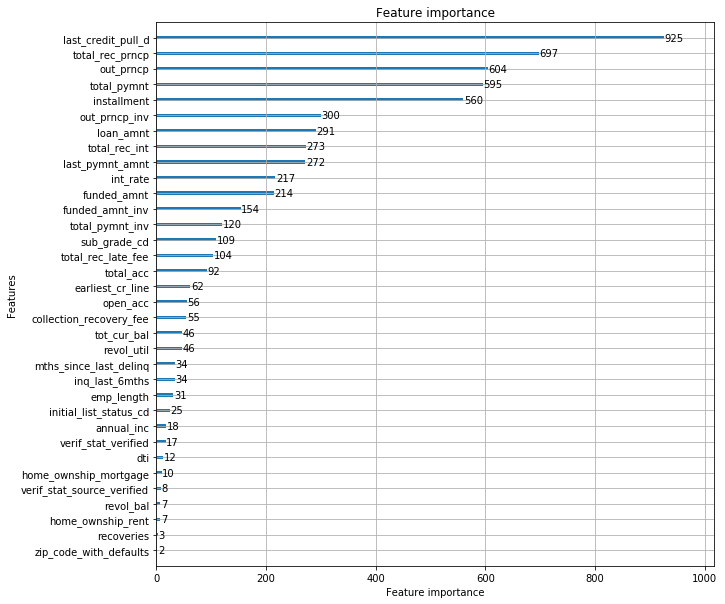

In [38]:
# LGBMClassifier gives plot_importances for free :)
f, ax = plt.subplots(figsize=(10,10))
plot_importance(gbm, ax=ax);

In [39]:
# !! work for the future

In [40]:
from xgboost import XGBClassifier

#### DNN

In [10]:
# and how about Deep Neural Nets? 
# this one is implemented in Keras with Tensorflow under the hood

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [25]:
# derive BinaryClassifier from KerasClassifier
# there are a lot of options to experiment with including 
# different layers, initializers, optimizers, activators, and so forth

class BinaryKerasClassifier(KerasClassifier):
    
    def __init__(self, *args, **kwargs):
        super(BinaryKerasClassifier,self).__init__(*args,**kwargs)
        return
        
    def __call__(self, N):
        # Create NN topology
        
        # model type
        net = Sequential()
        # input layer
        net.add(Dense(N, input_dim=N, kernel_initializer='normal', activation='relu')) # try tanh
        # for regularization
        net.add(Dropout(0.1))
        # hidden layer
        net.add(Dense(N, kernel_initializer='normal', activation='relu'))
        # for regularization
        net.add(Dropout(0.1))
        # output layer
        net.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
        # compilation
        net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # try RMSprop(lr=0.001)
        # et voila
        return net


In [33]:
dnn = BinaryKerasClassifier(N=X_train.shape[1], 
                       epochs=300, 
                       batch_size=10000, 
                       verbose=0)
ss_dnn = make_pipeline(StandardScaler(), dnn)

ss_dnn.fit(X_train, y_train)


predicted = ss_dnn.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    144943
          1       0.99      0.82      0.90     10349

avg / total       0.99      0.99      0.99    155292



In [35]:
mms.score_model(ss_dnn, X_train, y_train)

Scoring model StandardScaler-BinaryKerasClassifier by ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']
accuracy: 0.987 (std: 0.000)
precision: 0.990 (std: 0.002)
recall: 0.814 (std: 0.004)
f1: 0.894 (std: 0.001)
neg_log_loss: -0.053 (std: 0.003)
roc_auc: 0.977 (std: 0.000)
Fitting the model


In [ ]:
# !! work for the future

### Automatic ML

#### TPOT

In [13]:
from tpot import TPOTClassifier

In [14]:
# WARNING: this stuff takes a long time to run!

tpot = TPOTClassifier(scoring='roc_auc', generations=50, population_size=20, n_jobs=-1, verbosity=1)
tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))
tpot.export('tpot-pipeline.py')

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x7fa1d0820a20>>
Traceback (most recent call last):
  File "/home/omi/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


Best pipeline: DecisionTreeClassifier(DecisionTreeClassifier(DecisionTreeClassifier(DecisionTreeClassifier(input_matrix, criterion=gini, max_depth=7, min_samples_leaf=14, min_samples_split=3), criterion=gini, max_depth=8, min_samples_leaf=15, min_samples_split=5), criterion=entropy, max_depth=8, min_samples_leaf=10, min_samples_split=14), criterion=entropy, max_depth=10, min_samples_leaf=18, min_samples_split=11)
0.966095712766335


True

In [ ]:
# %load tpot-pipeline.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)

# Score on the training set was:0.9642429287568592
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=14, min_samples_split=3)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=15, min_samples_split=5)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=8, min_samples_leaf=10, min_samples_split=14)),
    DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=18, min_samples_split=11)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [51]:
# Trivia Question
# Q: How long did it take for TPOT to generate the stacking estimator that can be run in this cell? 
# A: About 10h (on my beefy laptop)

from sklearn.tree import DecisionTreeClassifier
from tpot.builtins import StackingEstimator

tpot_exported_pipeline = make_pipeline(
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=7, min_samples_leaf=14, min_samples_split=3)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=8, min_samples_leaf=15, min_samples_split=5)),
    StackingEstimator(estimator=DecisionTreeClassifier(criterion="entropy", max_depth=8, min_samples_leaf=10, min_samples_split=14)),
    DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_leaf=18, min_samples_split=11)
)

tpot_exported_pipeline.fit(X_train, y_train)

predicted = tpot_exported_pipeline.predict(X_test)
expected = y_test
print(classification_report(expected, predicted))

mms.score_model(tpot_exported_pipeline,X,y)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    144921
          1       0.99      0.80      0.88     10371

avg / total       0.99      0.99      0.98    155292

Scoring model StackingEstimator-StackingEstimator-StackingEstimator-DecisionTreeClassifier by ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc']
accuracy: 0.985 (std: 0.000)
precision: 0.982 (std: 0.002)
recall: 0.788 (std: 0.004)
f1: 0.877 (std: 0.002)
neg_log_loss: -0.083 (std: 0.004)
roc_auc: 0.963 (std: 0.000)
Fitting the model


In [53]:
mms.save_models()

"LC_MMS_predictive_models.pkl" dumped.


#### autosklearn

In [16]:
# !! work for the future

In [ ]:
# let's find out how good at finding the optimal model hyperparameters autosklearn is 

### Counter-balancing the imbalanced cases

#### SMOTe

In [26]:
# !! work for the future

In [2]:
from imblearn.over_sampling import SMOTE

#### Outlier detection

In [26]:
# !! work for the future

In [ ]:
# we got unbalanced classes (ca 93% good loans to 7% bad loans), so we may tryna outlier detection

In [3]:
from sklearn.ensemble import IsolationForest

In [4]:
from sklearn.neighbors import LocalOutlierFactor

### Clustering in search for new insights

In [ ]:
# !! work for the future

In [ ]:
# Clustering might reveal something interesting

In [5]:
from sklearn.manifold import TSNE

In [6]:
from sklearn.cluster import DBSCAN

In [7]:
from sklearn.cluster import AffinityPropagation

### And the best model is ...

In [37]:
# now's the time to select the best model

best_model_list = mms.list_models()

models_df = pd.DataFrame( best_model_list, columns=['model_name', 'accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc'])
models_df.sort_values(by='roc_auc', ascending=False, inplace=True)
models_df

,model_name,accuracy,precision,recall,f1,neg_log_loss,roc_auc
0,LGBMClassifier,0.987736,0.992940,0.821676,0.899036,-0.047224,0.982045
1,GradientBoostingClassifier,0.985118,0.995723,0.778319,0.873846,-0.054237,0.979801
2,StandardScaler-MLPClassifier,0.986757,0.986803,0.818235,0.892330,-0.051510,0.979307
3,StandardScaler-BinaryKerasClassifier,0.987050,0.990425,0.814285,0.893858,-0.052833,0.977432
4,RandomForestClassifier,0.985056,0.999344,0.774950,0.873104,-0.087779,0.971108
5,ExtraTreesClassifier,0.984391,0.999557,0.764990,0.866770,-0.088790,0.970707
6,StackingEstimator-StackingEstimator-StackingEs...,0.985255,0.982446,0.787989,0.877260,-0.082770,0.962697
7,DecisionTreeClassifier,0.984827,0.988603,0.783118,0.872868,-0.076041,0.961619
8,LogisticRegression,0.953843,0.592212,0.829868,0.675198,-0.208886,0.953524


In [38]:
# but ... how are you gonna decide?

# 'roc_auc' or 'neg_log_loss' seem good choices
# however the choice should be rather based on some objective business criteria 
# be it NPV, IRR, or some expected value of a monetary measure

from sklearn.metrics import make_scorer

def biz_specific_scoring_func(expected, predicted):
        # here calculate some ExpectedValue(some_biz_metric)
        # eg score = E(NPV)
        score = 0
        return score

score = make_scorer(biz_specific_scoring_func, greater_is_better=True)

In [39]:
# for now though, let's stick to roc_auc

model = mms.get_model(by_best_score='roc_auc')
model

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=200,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

###### [Move to the next notebook: *4. Testing*](4. Testing.ipynb)